<h2 style="text-align: center;">Telecom Churn Case Study</h2>
<p style="text-align: left;"><span style="color: #ff0000;">Note: Run this file with the base file - telecom_churn_data.csv</span></p>
<p style="text-align: left;">Business Objectives:&nbsp;</p>
<p style="text-align: left;">1. <span style="color: #808000;">To reduce customer churn</span>:&nbsp;<strong>predict which customers are at high risk of churn.</strong></p>
<p style="text-align: left;">2. <span style="color: #808000;">Build</span>: Predictive models to identify customers at high risk of churn and identify the main indicators of churn.</p>
<p style="text-align: left;">3. <span style="color: #808000;">Prepaid Customers:&nbsp;<span style="color: #000000;">We are focusing in South Eastern market where the bulk is prepaid customers.</span></span></p>
<p style="text-align: left;"><span style="color: #808000;"><span style="color: #000000;">4. We are <span style="color: #808000;">Targeting</span>: High Value Customers who might be churning based on usage statistics.</span></span></p>

In [139]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [140]:
#read the data
df_Churn = pd.read_csv('telecom_churn_data.csv',low_memory=False)
#get the feel of the data
df_Churn.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


### Check the shape of the data

In [141]:
df_Churn.shape

(99999, 226)

**Check the outliers**

In [283]:
def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.where((ys > upper_bound) | (ys < lower_bound))

### Check the null values in mobile_number

In [142]:
df_Churn['mobile_number'].isnull().sum()

0

 **Separate all columns that are indexed with '\_9'  to check the variance in the columns because we will be using to tag the churners later on.**    

In [143]:
cols1 = df_Churn.filter(like='_9').columns
cols2 = df_Churn.columns.difference(cols1)

### Since there are no null values for mobile number, let's check for the variance for every column

In [144]:
churn2 = df_Churn[cols2].copy()
mask = churn2.var()==0

In [145]:
mask[mask].index

Index(['circle_id', 'loc_ic_t2o_mou', 'loc_og_t2o_mou', 'std_ic_t2o_mou_6',
       'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8', 'std_og_t2c_mou_6',
       'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_og_t2o_mou'],
      dtype='object')

**Let's drop those columns**

In [146]:
churn2 = churn2.drop(mask[mask].index,axis = 1)

***check the date columns and start making a derived variable on the date difference***

In [147]:
date_list = churn2.select_dtypes(include='O').columns

Let's impute the null values with 0

In [148]:
churn2[date_list] = churn2[date_list].fillna(0)

### ***we'll make the difference between the last date of the recharge as a derived feature***

In [149]:
date_list

Index(['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8',
       'date_of_last_rech_data_6', 'date_of_last_rech_data_7',
       'date_of_last_rech_data_8', 'last_date_of_month_6',
       'last_date_of_month_7', 'last_date_of_month_8'],
      dtype='object')

### Function to calculate the duration of the days for every month

In [150]:
name_list = []
def get_day_difference(last_date,main_date):
    name = 'last_'+ main_date.name[-6:]
    churn2[name] = pd.to_datetime(churn2[last_date.name]).dt.day - pd.to_datetime(churn2[main_date.name]).dt.day
#   get the names of the new columns
    name_list.append(name)

In [151]:
get_day_difference(churn2['last_date_of_month_6'],churn2['date_of_last_rech_6'])
get_day_difference(churn2['last_date_of_month_6'],churn2['date_of_last_rech_data_6'])
get_day_difference(churn2['last_date_of_month_7'],churn2['date_of_last_rech_7'])
get_day_difference(churn2['last_date_of_month_7'],churn2['date_of_last_rech_data_7'])
get_day_difference(churn2['last_date_of_month_8'],churn2['date_of_last_rech_8'])
get_day_difference(churn2['last_date_of_month_8'],churn2['date_of_last_rech_data_8'])

In [152]:
## new feature names are
name_list

['last_rech_6',
 'last_data_6',
 'last_rech_7',
 'last_data_7',
 'last_rech_8',
 'last_data_8']

Let us drop the end date columns as they have 0 variance

In [153]:
churn2 = churn2.drop(['last_date_of_month_6','last_date_of_month_7','last_date_of_month_8'],axis=1)

In [154]:
df_Churn_June = churn2.filter(like='_6', axis=1)
df_Churn_July = churn2.filter(like='_7', axis=1)
df_Churn_August = churn2.filter(like='_8', axis=1)

In [155]:

df_Churn_June_num = df_Churn_June.select_dtypes(include = ['float64', 'int64'])
df_Churn_June_num.head()

,arpu_2g_6,arpu_3g_6,arpu_6,av_rech_amt_data_6,count_rech_2g_6,count_rech_3g_6,fb_user_6,ic_others_6,isd_ic_mou_6,isd_og_mou_6,...,std_og_t2t_mou_6,total_ic_mou_6,total_og_mou_6,total_rech_amt_6,total_rech_data_6,total_rech_num_6,vol_2g_mb_6,vol_3g_mb_6,last_rech_6,last_data_6
0,212.17,212.17,197.385,252.0,0.0,1.0,1.0,NaN,NaN,NaN,...,NaN,0.00,0.00,362,1.0,4,30.13,83.57,9,9
1,NaN,NaN,34.047,NaN,NaN,NaN,NaN,0.00,1.83,0.0,...,0.23,26.83,40.31,74,NaN,4,0.00,0.00,1,29
2,NaN,NaN,167.690,NaN,NaN,NaN,NaN,0.93,0.00,0.0,...,4.34,370.04,155.33,168,NaN,5,0.00,0.00,13,29
3,NaN,NaN,221.338,NaN,NaN,NaN,NaN,0.00,0.00,0.0,...,26.23,280.08,223.23,230,NaN,10,0.00,0.00,2,29
4,0.00,0.00,261.636,56.0,1.0,0.0,0.0,0.48,0.00,0.0,...,0.00,216.44,127.28,196,1.0,5,0.00,0.00,4,26


#### we'll try to find which features are strongly correlated with revenue or arpu. 
#### We'll store them in list 

In [156]:
df_Churn_June_num = df_Churn_June.select_dtypes(include = ['float64', 'int64'])
df_Churn_June_num.head()

#### we'll try to find which features are strongly correlated with revenue or arpu. 
#### We'll store them in list 

df_Churn_June_num = df_Churn_June_num.corr()['arpu_6'][:-1] # -1 because the latest row is arpu_6

imp_features_list_june = df_Churn_June_num[abs(df_Churn_June_num) > 0.5].sort_values(ascending=False)
print("There is {} strongly correlated values with revenue for June:\n{}".format(len(imp_features_list_june), imp_features_list_june))

df_Churn_July_num = df_Churn_July.select_dtypes(include = ['float64', 'int64'])

df_Churn_July_num = df_Churn_July_num.corr()['arpu_7'][:-1] # -1 because the latest row is arpu_7

imp_features_list_july = df_Churn_July_num[abs(df_Churn_July_num) > 0.5].sort_values(ascending=False)
print("There is {} strongly correlated values with revenue for July:\n{}".format(len(imp_features_list_july), imp_features_list_july))

df_Churn_August_num = df_Churn_August.select_dtypes(include = ['float64', 'int64'])

df_Churn_August_num = df_Churn_August_num.corr()['arpu_8'][:-1] # -1 because the latest row is arpu_7

imp_features_list_August = df_Churn_August_num[abs(df_Churn_August_num) > 0.5].sort_values(ascending=False)
print("There is {} strongly correlated values with revenue for August:\n{}".format(len(imp_features_list_August), imp_features_list_August))

There is 5 strongly correlated values with revenue for June:
arpu_6              1.000000
total_rech_amt_6    0.953017
total_og_mou_6      0.675876
offnet_mou_6        0.620054
total_rech_num_6    0.508769
Name: arpu_6, dtype: float64
There is 5 strongly correlated values with revenue for July:
arpu_7              1.000000
total_rech_amt_7    0.951995
total_og_mou_7      0.663038
offnet_mou_7        0.603864
arpu_3g_7           0.509490
Name: arpu_7, dtype: float64
There is 5 strongly correlated values with revenue for August:
arpu_8              1.000000
total_rech_amt_8    0.955952
total_og_mou_8      0.656806
offnet_mou_8        0.599479
max_rech_amt_8      0.501507
Name: arpu_8, dtype: float64


### So after checking june , july and august important features are:

- **total recharge amount**
- **total outgoing minutes of usage**
- **offnet minutes of usage**
- **max recharge amount** 
- **revenue for 3g**

***Let's tag the high value customers now***

In [157]:
# Calculating the threshold recharge value to define high value customer

th_rech_val = churn2[["total_rech_amt_6","total_rech_amt_7"]].mean(axis = 1).quantile(0.7)
print("The threshold recharge value is: {}".format(th_rech_val))

The threshold recharge value is: 368.5


In [158]:
df_amt = churn2.filter(like='total_rech_amt')
df_amt.iloc[:,0:2].head()

,total_rech_amt_6,total_rech_amt_7
0,362,252
1,74,384
2,168,315
3,230,310
4,196,350


In [159]:
df_amt['mobile_number'] = churn2['mobile_number']

In [160]:
df_amt['total_rech_amt_6_7'] = (df_amt['total_rech_amt_6']+df_amt['total_rech_amt_7'])/2

In [161]:
df_amt.head()

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,mobile_number,total_rech_amt_6_7
0,362,252,252,7000842753,307.0
1,74,384,283,7001865778,229.0
2,168,315,116,7001625959,241.5
3,230,310,601,7001204172,270.0
4,196,350,287,7000142493,273.0


In [162]:
df_amt=df_amt[['mobile_number','total_rech_amt_6','total_rech_amt_7','total_rech_amt_6_7','total_rech_amt_8']]

***I need to predict churn only for the high-value customers. Define high-value customers as follows: Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).***

In [163]:
##get the 70th percentile for the total recharge amount
p = df_amt['total_rech_amt_6_7'].quantile(0.7)
p
##any users less than this amount can be ignored

368.5

In [164]:
df_amt[df_amt['total_rech_amt_6_7']>=p].shape

(30011, 5)

In [165]:
df_amt_final = df_amt[df_amt['total_rech_amt_6_7']>=p]

In [166]:
df_amt_final.shape

(30011, 5)

We need to subset these mobile numbers from this data set on the entire data set

In [167]:
df_final = churn2[churn2['mobile_number'].isin(df_amt_final['mobile_number'])]

Let's add the mobile number before merging the 9th month columns

In [168]:
col_list = list(cols1)
col_list.append('mobile_number')

In [169]:
df_Churn[col_list].head()

,last_date_of_month_9,arpu_9,onnet_mou_9,offnet_mou_9,roam_ic_mou_9,roam_og_mou_9,loc_og_t2t_mou_9,loc_og_t2m_mou_9,loc_og_t2f_mou_9,loc_og_t2c_mou_9,...,vol_3g_mb_9,arpu_3g_9,arpu_2g_9,night_pck_user_9,monthly_2g_9,sachet_2g_9,monthly_3g_9,sachet_3g_9,fb_user_9,mobile_number
0,9/30/2014,21.100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,NaN,NaN,NaN,0,0,0,0,NaN,7000842753
1,9/30/2014,86.285,18.34,53.76,0.00,0.00,18.34,53.76,0.00,0.00,...,0.00,NaN,NaN,NaN,0,0,0,0,NaN,7001865778
2,9/30/2014,290.714,74.81,118.91,38.49,70.94,14.39,28.16,22.24,0.48,...,8.42,2.84,0.0,0.0,0,1,0,0,1.0,7001625959
3,9/30/2014,389.500,241.71,113.54,0.00,0.00,15.49,65.46,2.06,0.00,...,0.00,NaN,NaN,NaN,0,0,0,0,NaN,7001204172
4,9/30/2014,163.426,58.78,45.81,0.00,0.00,58.78,37.89,1.93,0.00,...,0.00,NaN,NaN,NaN,0,0,0,0,NaN,7000142493


In [170]:
churn3 = pd.merge(df_final,df_Churn[col_list],on='mobile_number',how='inner')

## Let us mark the churners now since we have already got the high value cutomers from the above pre-processing. 

In this project, we will use the usage-based definition to define churn.
Tag churners and remove attributes of the churn phase.Tag the churned customers (churn=1, else 0) based on the fourth month as follows: Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase. The attributes we will need to use to tag churners are:
<br>
- __total_ic_mou_9__
- __total_og_mou_9__
- __vol_2g_mb_9__
- __vol_3g_mb_9__
<br>

***After tagging churners, remove all the attributes corresponding to the churn phase (all attributes having ‘ _9’, etc. in their names).***

In [171]:
churn_attr = ['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9']
churn3['churn'] = churn3[churn_attr].sum(axis=1).map(lambda x: 1 if x == 0 else 0)

Let's make a copy and drop the attributes having _9

In [172]:
drop_list = churn3.filter(like='_9')

In [173]:
telecom_churn = churn3.drop(drop_list,axis=1).copy()

Let's check out the shape again

In [174]:
telecom_churn.shape

(30011, 166)

**We have around 30011 columns and 166 features, we'll further remove the features after doing a PCA on the features**

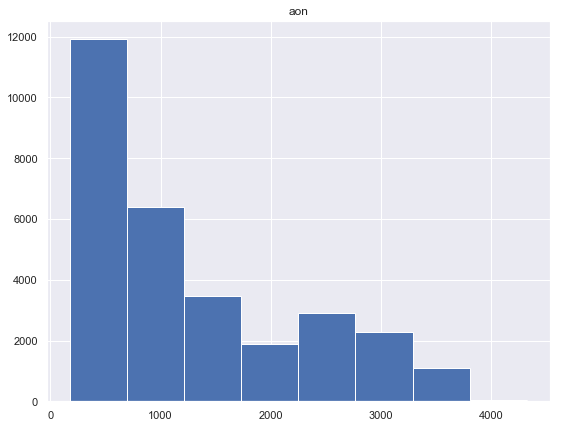

In [175]:
ax = telecom_churn.hist(column='aon', bins=8,figsize=(9,7))

Let's check out the ditribution for the new derived features ['last_rech_6','last_data_6','last_rech_7','last_data_7','last_rech_8','last_data_8']

In [176]:
new_features = ['last_rech_6','last_data_6','last_rech_7','last_data_7','last_rech_8','last_data_8']

(array([ 3268.,  2106.,  1415.,  1012.,  1271.,  1185.,  1040., 18714.]),
 array([ 0.  ,  3.75,  7.5 , 11.25, 15.  , 18.75, 22.5 , 26.25, 30.  ]),
 <a list of 8 Patch objects>)

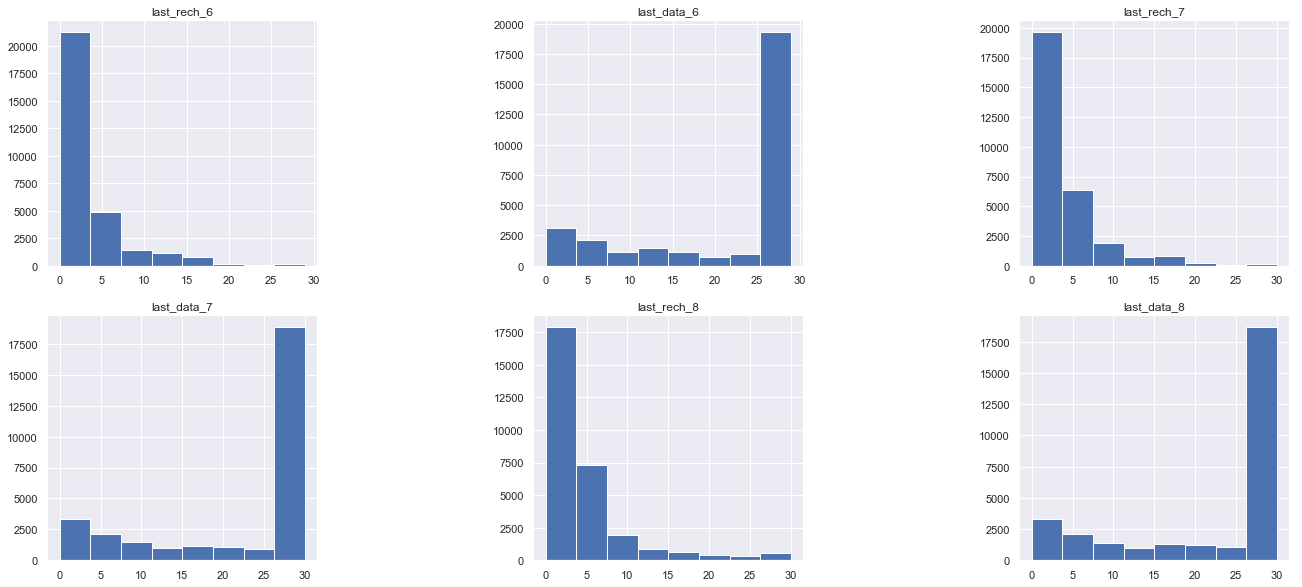

In [177]:
plt.subplots_adjust(left=None, bottom=None, right=3, top=2, wspace=0.8, hspace=None)
plt.subplot(231)
plt.title(new_features[0])
plt.hist(telecom_churn[new_features[0]],bins=8)
plt.subplot(232)
plt.title(new_features[1])
plt.hist(telecom_churn[new_features[1]],bins=8)
plt.subplot(233)
plt.title(new_features[2])
plt.hist(telecom_churn[new_features[2]],bins=8)
plt.subplot(234)
plt.title(new_features[3])
plt.hist(telecom_churn[new_features[3]],bins=8)
plt.subplot(235)
plt.title(new_features[4])
plt.hist(telecom_churn[new_features[4]],bins=8)
plt.subplot(236)
plt.title(new_features[5])
plt.hist(telecom_churn[new_features[5]],bins=8)
# fig.tight_layout()

From the above figures we can see that
- most people will recharge for data near the end of the month
- most people will recharge for talk time towards the beginning of the month

__Let's check the churn percentage__

In [178]:
churn = (sum(telecom_churn['churn'])/len(telecom_churn['churn'].index))*100
print ("churn percentage ",churn)

churn percentage  8.64016527273333


## The churn percentage is very low and there is a class imbalance so we need to be careful while trying to tune the parameters for predicting the values

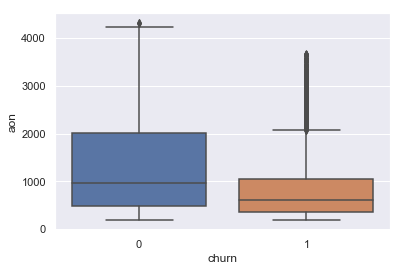

In [179]:
sns.boxplot(x = 'churn', y ='aon', data = telecom_churn)

<p style="text-align: left;"><strong>We can conclude two things from the above subplot:</strong><br /><span style="color: #0000ff;">- Churners are having relatively low age on networks compared to non churners&para;</span><br /><span style="color: #0000ff;">- Churn data has more outliers as compared to non-churners</span></p>

__Let's look at the Average Revenue Per Month__

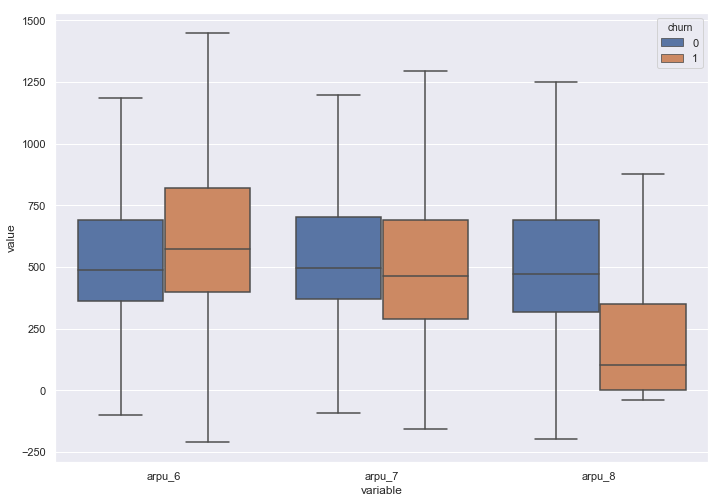

In [180]:
mdf = pd.melt(telecom_churn[['arpu_6','arpu_7','arpu_8','churn']], id_vars=['churn'],value_vars=['arpu_6','arpu_7','arpu_8'])
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(x = 'variable', y = 'value', hue = 'churn', data = mdf, showfliers=False)

__From above analysis it is evident that for churners, average revenue per user falls in general while going from month June to August__

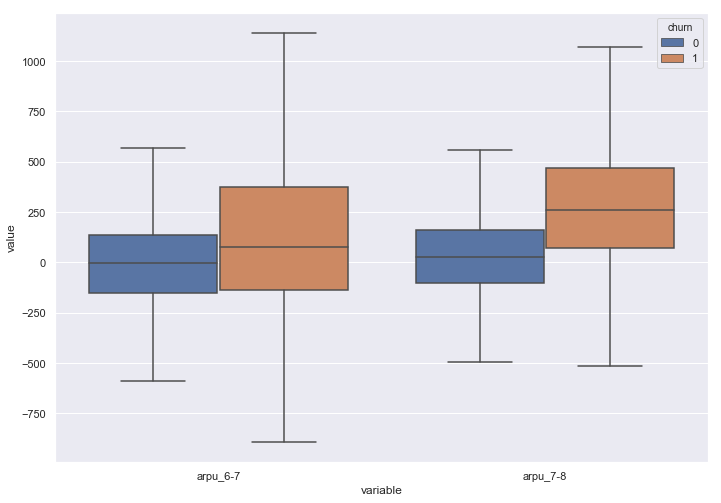

In [181]:
telecom_churn['arpu_6-7'] = telecom_churn['arpu_6'] -  telecom_churn['arpu_7']
telecom_churn['arpu_7-8'] = telecom_churn['arpu_7'] -  telecom_churn['arpu_8']

mdf = pd.melt(telecom_churn[['arpu_6-7','arpu_7-8','churn']], id_vars=['churn'],value_vars=['arpu_6-7','arpu_7-8'])

sns.boxplot(x = 'variable', y = 'value', hue = 'churn', data = mdf, showfliers=False)

**From above analysis it is evident that difference in average revenue per user is a discriminative factor for predicting churner and non churner**

<p style="text-align: left;"><span style="color: #0000ff;"><strong>We need to check for null values in the entire data set again.</strong></span><br /><span style="color: #0000ff;"><strong>Let's fill them with 0 because if we impute them with data, it will provide improper information on the columns</strong></span></p>

In [182]:
telecom_churn = telecom_churn.fillna(0)

In [183]:
##First check for categorical values
telecom_churn.nunique().sort_values().head(10)

night_pck_user_6    2
night_pck_user_8    2
fb_user_8           2
fb_user_7           2
fb_user_6           2
night_pck_user_7    2
churn               2
monthly_2g_6        5
monthly_2g_7        6
monthly_2g_8        6
dtype: int64

Let's make a category list of these 7 components

In [184]:
cat_list = telecom_churn.nunique().sort_values()[0:7].index

In [185]:
cat_list

Index(['night_pck_user_6', 'night_pck_user_8', 'fb_user_8', 'fb_user_7',
       'fb_user_6', 'night_pck_user_7', 'churn'],
      dtype='object')

**Dimensionality Reduction -1**

- Let's start with PCA and check the model characteristics

In [186]:
dt_list = list(telecom_churn.filter(like = 'date').columns)

In [187]:
dt_list

['date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8',
 'date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8']

***Let's make a function to extract just the date from the columns***

In [188]:
def get_day(X):
    telecom_churn[X] = pd.to_datetime(telecom_churn[X]).dt.day
for cols in dt_list:
    get_day(cols)

In [189]:
## add the derived date features to this list to keep from normalizing
dt_list.extend(name_list)
## add the categorical to this list to keep from normalizing
dt_list.extend(cat_list)
dt_list

['date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8',
 'date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8',
 'last_rech_6',
 'last_data_6',
 'last_rech_7',
 'last_data_7',
 'last_rech_8',
 'last_data_8',
 'night_pck_user_6',
 'night_pck_user_8',
 'fb_user_8',
 'fb_user_7',
 'fb_user_6',
 'night_pck_user_7',
 'churn']

In [190]:
norm_list= telecom_churn.columns.difference(dt_list)

In [191]:
##Let's make a copy of the data set before proceedings
PCA_churn = telecom_churn.copy()

**Let's split the Train and test, we will standardise them separately**

In [226]:
X = PCA_churn.drop(['churn','mobile_number'],axis=1)
y = PCA_churn['churn']

Import the libraries to split and perform PCA, to identify the components and use Logistic regression as our classifier

In [227]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [228]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=100)

In [229]:
n_list = norm_list.drop(labels='mobile_number')

In [230]:
#on Train
X_train[n_list] = (X_train[n_list]-X_train[n_list].mean())/X_train[n_list].std()

In [231]:
#on Test
X_test[n_list] = (X_test[n_list]-X_test[n_list].mean())/X_test[n_list].std()

Let's make the PCA object

In [232]:
pca = PCA(svd_solver='randomized', random_state=50)
# fit the train set
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=50,
  svd_solver='randomized', tol=0.0, whiten=False)

Now we'll Try to see the components explained by the two components

In [233]:
colnames = list(X_train.columns)
pcs_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'Feature':colnames})
pcs_df.head()

,PC1,PC2,Feature
0,0.000548,-0.000261,aon
1,0.018206,0.013274,arpu_2g_6
2,0.018917,0.005608,arpu_2g_7
3,0.019082,-0.010100,arpu_2g_8
4,0.017311,0.012513,arpu_3g_6


<p style="text-align: left;">5 most important features according to PCA are:</p>
<p style="text-align: left;"><span style="color: #0000ff;">- aon(age on network)</span></p>
<p style="text-align: left;"><span style="color: #0000ff;">- arpu(average revenue per user) for 2g 6,7,8</span></p>
<p style="text-align: left;"><span style="color: #0000ff;">- arpu 3g 6th month</span></p>

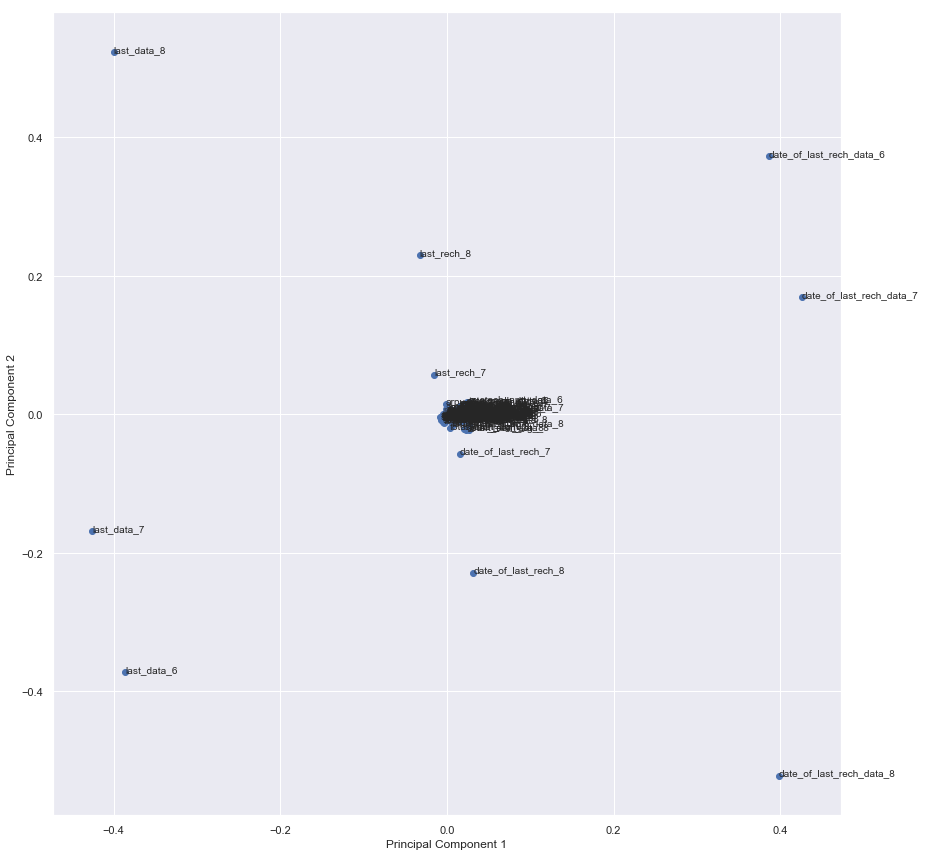

In [234]:
%matplotlib inline
fig = plt.figure(figsize = (13,12))
plt.scatter(pcs_df.PC1, pcs_df.PC2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i, txt in enumerate(pcs_df.Feature):
    plt.annotate(txt, (pcs_df.PC1[i],pcs_df.PC2[i]))
plt.tight_layout()
plt.show()

Let's plot and select the right number of components required

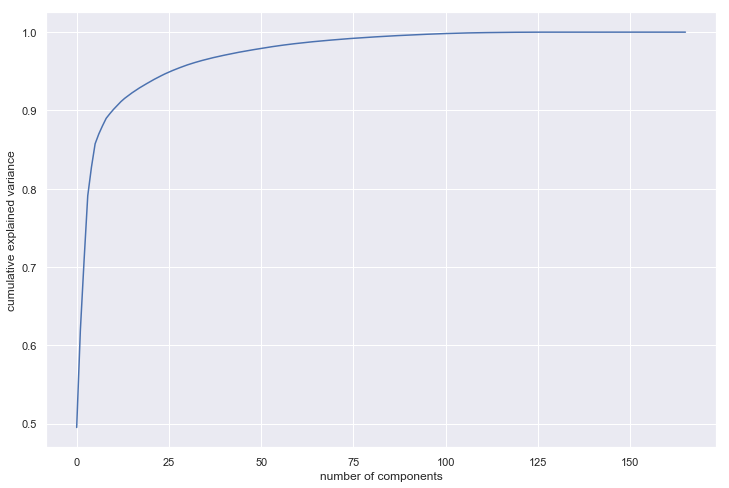

In [235]:
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

<p style="text-align: left;"><span style="color: #800000;"><strong>We see that 50 components can explain more than 95% of the variance in the data set, so we will use 50 components</strong></span></p>

In [236]:
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=50)

In [237]:
df_train_pca = pca_final.fit_transform(X_train)
df_train_pca.shape

(21007, 50)

In [238]:
corrmat = np.corrcoef(df_train_pca.transpose())
corrmat_nodiag = corrmat - np.diagflat(corrmat.diagonal())
print("max corr:",corrmat_nodiag.max(), ", min corr: ", corrmat_nodiag.min(),)

max corr: 0.032754424201774615 , min corr:  -0.02159830730844615


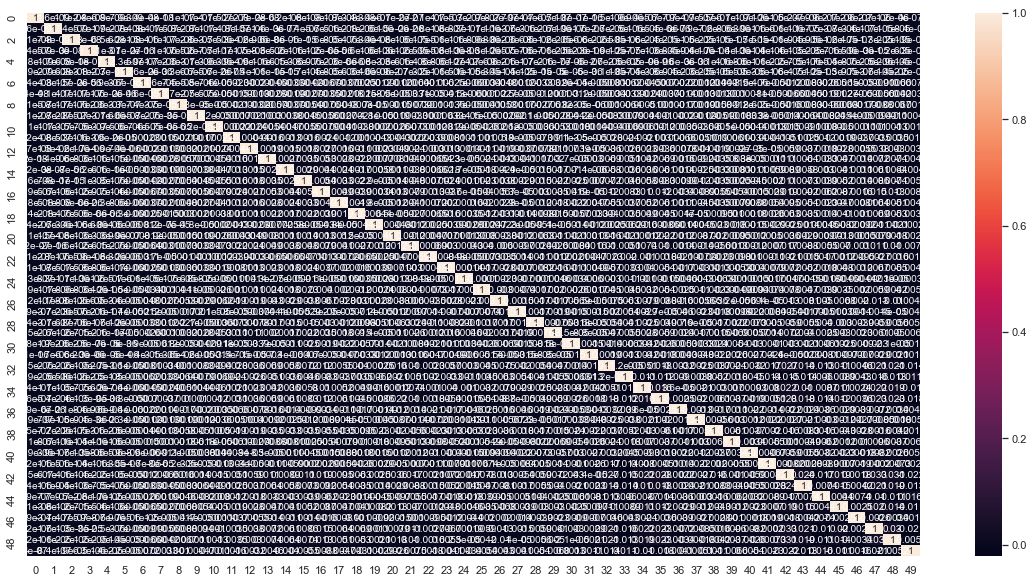

In [239]:
import seaborn as sns
%matplotlib inline
plt.figure(figsize = (20,10))
sns.heatmap(corrmat,annot = True)

__Let's transform the test set as well__

In [240]:
df_test_pca = pca_final.transform(X_test)
df_test_pca.shape

(9004, 50)

In [241]:
from sklearn import metrics

learner_pca = LogisticRegression()
model_pca = learner_pca.fit(df_train_pca,y_train)

In [242]:
#Making prediction on the test data
pred_probs_test = model_pca.predict_proba(df_test_pca)[:,1]
"{}".format(metrics.roc_auc_score(y_test, pred_probs_test))

'0.898157781009372'

<p style="text-align: left;"><span style="color: #000080;"><strong>Functions for model evaluation-</strong></span><br /><span style="color: #339966;">-&nbsp;<span style="color: #808000;">probability_df(pred_probs_test,y_test)</span>: Returns a dataframe of the test and the probabilities.</span></p>
<p style="text-align: left;"><span style="color: #339966;">-&nbsp;<span style="color: #808000;">model_evaluation(y_pred_final)</span>: Returns the dataframe with different probability thresholds.</span></p>
<p style="text-align: left;"><span style="color: #339966;">-&nbsp;<span style="color: #808000;">probability_cutoff(y_pred_final)</span>: Returns metrics at probability thresholds.</span></p>
<p style="text-align: left;"><span style="color: #339966;">-&nbsp;<span style="color: #808000;">final_model(y_pred_final)</span>: Gets us the final predicted model, threshold is 0.1 in our case.</span></p>
<p style="text-align: left;"><span style="color: #339966;">-<span style="color: #808000;">&nbsp;draw_roc( actual, probs )</span>: Draws the ROC curve for our model at specific threshold</span></p>

In [243]:
def probability_df(pred_probs_test,y_test):
    y_pred_df = pd.DataFrame(pred_probs_test)
    y_pred_1 = y_pred_df.iloc[:,[0]]
    y_test_df = pd.DataFrame(y_test)
    y_pred_1.reset_index(drop=True, inplace=True)
    y_test_df.reset_index(drop=True, inplace=True)
    y_pred_final = pd.concat([y_test_df,y_pred_1],axis=1)
    y_pred_final= y_pred_final.rename(columns={ 0: 'churn_Prob'})
    y_pred_final['predicted'] = y_pred_final.churn_Prob.map(lambda x: 1 if x > 0.5 else 0)
    confusion = metrics.confusion_matrix(y_pred_final.churn, y_pred_final.predicted)
    display(confusion)
    return y_pred_final

In [244]:
def model_evaluation(y_pred_final):
    numbers = [float(x)/10 for x in range(10)]
    for i in numbers:
        y_pred_final[i]= y_pred_final.churn_Prob.map( lambda x: 1 if x > i else 0)
    display(y_pred_final.head())

In [245]:
def probability_cutoff(y_pred_final):
    cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
    num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    for i in num:
        cm1 = metrics.confusion_matrix(y_pred_final.churn, y_pred_final[i])
        total1=sum(sum(cm1))
        accuracy = (cm1[0,0]+cm1[1,1])/total1
        sensi = cm1[0,0]/(cm1[0,0]+cm1[0,1])
        speci = cm1[1,1]/(cm1[1,0]+cm1[1,1])
        cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
    print(cutoff_df)
    return accuracy,sensi,speci,cutoff_df

In [246]:
def final_model(y_pred_final):
    y_pred_final['final_predicted'] = y_pred_final.churn_Prob.map(lambda x: 1 if x > 0.10 else 0)
    confusion = metrics.confusion_matrix(y_pred_final.churn, y_pred_final.final_predicted)
    display(confusion)
    display(metrics.accuracy_score(y_pred_final.churn, y_pred_final.final_predicted))

In [247]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 4))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, thresholds

In [248]:
y_pred_final = probability_df(pred_probs_test,y_test)

array([[8139,   95],
       [ 560,  210]], dtype=int64)

In [249]:
model_evaluation(y_pred_final)

,churn,churn_Prob,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.587831,1,1,1,1,1,1,1,0,0,0,0
1,0,0.376479,0,1,1,1,1,0,0,0,0,0,0
2,0,0.011990,0,1,0,0,0,0,0,0,0,0,0
3,0,0.025379,0,1,0,0,0,0,0,0,0,0,0
4,0,0.022408,0,1,0,0,0,0,0,0,0,0,0


In [250]:
accuracy,sensi,speci,cutoff_df = probability_cutoff(y_pred_final)

     prob  accuracy     sensi     speci
0.0   0.0  0.085518  0.000000  1.000000
0.1   0.1  0.831853  0.832281  0.827273
0.2   0.2  0.907597  0.926767  0.702597
0.3   0.3  0.928032  0.960772  0.577922
0.4   0.4  0.929920  0.979718  0.397403
0.5   0.5  0.927255  0.988462  0.272727
0.6   0.6  0.927588  0.995749  0.198701
0.7   0.7  0.924589  0.998057  0.138961
0.8   0.8  0.922035  0.999028  0.098701
0.9   0.9  0.920702  0.999636  0.076623


<Figure size 2880x2880 with 0 Axes>

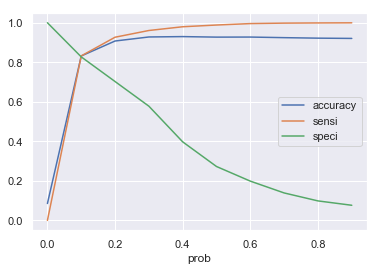

In [251]:
plt.figure(figsize=(40,40))
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

Let's check the confusion matrix

In [252]:
final_model(y_pred_final)

array([[6853, 1381],
       [ 133,  637]], dtype=int64)

0.8318525099955575

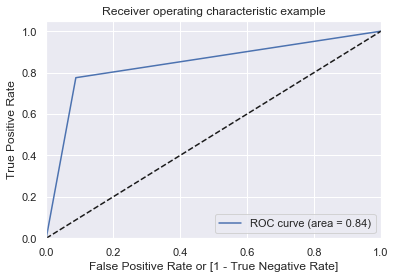

In [409]:
fig1 = draw_roc(y_pred_final.churn, y_pred_final.final_predicted)

**Model Evaluation**

In [254]:
# Predicted     not_churn    churn
# Actual
# not_churn        1326      166
# churn            249       333  

<span style="color:red"><b>Specificity = 83% and Accuracy = 83%</b></span>

<b>Grid Search on the Principal components with Logistic Regression<b>

In [ ]:
##df_train_pca
##df_test_pca

In [411]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import GridSearchCV
logsk = LogisticRegression()
penalty = ['l1', 'l2']
C = np.logspace(0, 4, 10)
hyperparameters = dict(C=C, penalty=penalty)
clf = GridSearchCV(estimator = logsk,param_grid = hyperparameters, cv=5, verbose=0,scoring='accuracy',return_train_score=True)
model_cv = clf.fit(df_train_pca, y_train)

In [412]:
cv_results = pd.DataFrame(model_cv.cv_results_)
display(cv_results.head(2))
print (model_cv.best_score_)
print (model_cv.best_params_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,3.458921,2.962755,0.001296,0.000403,1,l1,"{'C': 1.0, 'penalty': 'l1'}",0.92099,0.920752,0.924084,...,0.923264,0.002198,20,0.924725,0.92526,0.923416,0.922587,0.924139,0.924025,0.000945
1,0.781887,0.264914,0.001204,0.000246,1,l2,"{'C': 1.0, 'penalty': 'l2'}",0.92099,0.920514,0.924560,...,0.923406,0.002379,14,0.924963,0.92526,0.923416,0.922885,0.924139,0.924132,0.000898


0.923596896272671
{'C': 21.544346900318832, 'penalty': 'l2'}


Let's find the optimal value of K before trying further models as we will need to cross validate as well

In [255]:
shape = X_train.shape[0]
partition_size = shape*0.2
#assuming we will keep aside 20 percent of data for the test partition
print("partition size",partition_size,"k-value-",round(shape/partition_size))

partition size 4201.400000000001 k-value- 5


 **Let's drop highly correlated columns, since we are already done by PCA** 

In [256]:
def correl(X_train):
    cor = X_train.corr()
    corrm = np.corrcoef(X_train.transpose())
    corr = corrm - np.diagflat(corrm.diagonal())
    print("max corr:",corr.max(), ", min corr: ", corr.min())
    c1 = cor.stack().sort_values(ascending=False).drop_duplicates()
    high_cor = c1[c1.values!=1]
    thresh = 0.8
    ## change this value to get more correlation results
    return(high_cor[high_cor>thresh])

In [257]:
cor_list = correl(X[n_list]).index.get_level_values(1)

max corr: 0.9816066688567621 , min corr:  -0.4710234167593783


In [300]:
cor_list

Index(['count_rech_2g_8', 'sachet_2g_7', 'sachet_2g_6', 'arpu_8',
       'isd_og_mou_7', 'arpu_6', 'total_rech_amt_7', 'arpu_3g_6', 'arpu_3g_8',
       'arpu_2g_7', 'isd_og_mou_6', 'isd_og_mou_7', 'total_ic_mou_6',
       'loc_ic_mou_8', 'av_rech_amt_data_6', 'loc_ic_mou_7', 'count_rech_2g_8',
       'count_rech_2g_7', 'count_rech_2g_6', 'total_rech_data_8',
       'total_rech_data_7', 'arpu_2g_8', 'sachet_3g_8', 'sachet_2g_6',
       'arpu_2g_7', 'arpu_2g_8', 'monthly_3g_7', 'onnet_mou_8',
       'loc_ic_t2m_mou_8', 'std_og_t2t_mou_7', 'arpu_3g_6', 'loc_ic_t2m_mou_6',
       'std_og_t2m_mou_7', 'onnet_mou_6', 'count_rech_3g_7',
       'std_og_t2m_mou_8', 'monthly_3g_6', 'std_ic_t2m_mou_8', 'monthly_3g_7',
       'std_og_mou_8', 'arpu_3g_8', 'arpu_3g_8', 'count_rech_3g_6',
       'total_og_mou_7', 'av_rech_amt_data_7', 'loc_ic_t2m_mou_7',
       'loc_ic_mou_7', 'loc_og_mou_7', 'arpu_3g_6', 'max_rech_data_8',
       'loc_og_t2t_mou_7', 'max_rech_data_7', 'offnet_mou_6', 'std_og_mou_6',


***let us drop the high correlation columns on one side***

In [259]:
X = X.drop(cor_list,axis=1)

### Dimensionality Reduction - 2

**Let's split the data set again**

In [266]:
X.nunique().sort_values(ascending = True)##Take the first 6 values

fb_user_8                       2
night_pck_user_7                2
night_pck_user_6                2
fb_user_7                       2
fb_user_6                       2
night_pck_user_8                2
monthly_2g_6                    5
monthly_2g_8                    6
monthly_2g_7                    6
monthly_3g_8                   12
sachet_3g_6                    25
sachet_3g_7                    27
count_rech_3g_8                29
last_rech_6                    30
last_data_6                    30
date_of_last_rech_6            30
date_of_last_rech_data_6       30
last_data_7                    31
last_rech_7                    31
date_of_last_rech_data_8       31
date_of_last_rech_data_7       31
date_of_last_rech_8            31
last_rech_8                    31
date_of_last_rech_7            31
last_data_8                    31
sachet_2g_8                    34
total_rech_data_6              37
max_rech_data_6                44
spl_ic_mou_6                   78
spl_ic_mou_8  

In [267]:
cat_list = list(X.nunique().sort_values(ascending = True)[0:6].index)
dt_list = list(X.filter(like='date'))
cat_list.extend(name_list)
cat_list.extend(dt_list)

In [268]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=100)

In [269]:
#Standardise the train and test
X_train[cat_list] = (X_train[cat_list]-X_train[cat_list].mean())/X_train[cat_list].std()
X_test[cat_list] = (X_test[cat_list]-X_test[cat_list].mean())/X_test[cat_list].std()

**Let's try Recursive feature elimination with cross validation and random forest classification to reduce the number of features and check if our derived features contribute much**
<br>
<span style="color:red"><b>WARNING:</b></span>
<span style="color:red">May take long running times</span>

In [270]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

#suppress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

clf_rf_4 = RandomForestClassifier(class_weight="balanced") 
#The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data

rfecv = RFECV(estimator=clf_rf_4, step=1,cv=5,scoring='roc_auc') 
#5-fold cross-validation with scoring as auc because accuracy will not work for imbalanced class

rfecv = rfecv.fit(X_train, y_train)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train.columns[rfecv.support_])

Optimal number of features : 26
Best features : Index(['aon', 'arpu_7', 'date_of_last_rech_8', 'date_of_last_rech_data_8',
       'last_day_rch_amt_8', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8',
       'loc_og_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2t_mou_8',
       'max_rech_amt_8', 'offnet_mou_7', 'onnet_mou_7', 'roam_ic_mou_8',
       'roam_og_mou_8', 'std_ic_mou_8', 'std_og_mou_7', 'total_ic_mou_7',
       'total_og_mou_6', 'total_og_mou_8', 'total_rech_amt_8',
       'total_rech_num_6', 'total_rech_num_7', 'last_rech_8', 'arpu_6-7',
       'arpu_7-8'],
      dtype='object')


We got 26 features in the last run


In [271]:
optimal_cols = X_train.columns[rfecv.support_]

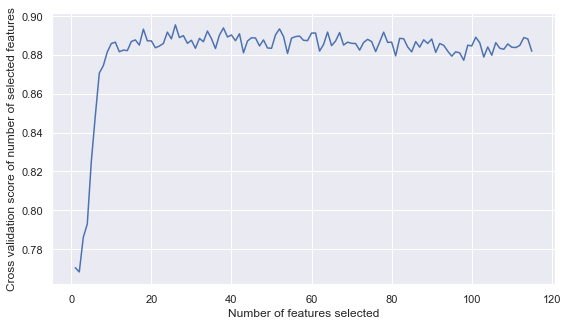

In [272]:
## for k = 5
plt.figure(figsize=(9,5))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [273]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import GridSearchCV
logsk = LogisticRegression()
penalty = ['l1', 'l2']
C = np.logspace(0, 4, 10)
hyperparameters = dict(C=C, penalty=penalty)
clf = GridSearchCV(estimator = logsk,param_grid = hyperparameters, cv=5, verbose=0,scoring='accuracy',return_train_score=True)
model_cv = clf.fit(X_train[optimal_cols], y_train)

In [274]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.361428,0.044713,0.001391,0.000195,1,l1,"{'C': 1.0, 'penalty': 'l1'}",0.920990,0.923132,0.924084,...,0.922692,0.001173,1,0.923297,0.922940,0.922464,0.923063,0.923365,0.923026,0.000320
1,2.249338,0.412665,0.001705,0.000245,1,l2,"{'C': 1.0, 'penalty': 'l2'}",0.921228,0.922894,0.924084,...,0.922692,0.001093,1,0.923297,0.922702,0.922583,0.923004,0.923306,0.922978,0.000297
2,0.372648,0.084366,0.001291,0.000236,2.78256,l1,"{'C': 2.7825594022071245, 'penalty': 'l1'}",0.920990,0.923132,0.924084,...,0.922692,0.001173,1,0.923297,0.922999,0.922583,0.923063,0.923246,0.923038,0.000253
3,2.245232,0.235706,0.001704,0.000246,2.78256,l2,"{'C': 2.7825594022071245, 'penalty': 'l2'}",0.920514,0.922894,0.924084,...,0.922454,0.001238,18,0.923297,0.922940,0.922583,0.922885,0.923365,0.923014,0.000287
4,0.392739,0.178958,0.001388,0.000193,7.74264,l1,"{'C': 7.742636826811269, 'penalty': 'l1'}",0.920752,0.923132,0.924084,...,0.922645,0.001244,10,0.923356,0.922999,0.922583,0.923063,0.923246,0.923049,0.000266


Let us check the best Hyperparameters vs the accuracy

In [289]:
print (model_cv.best_score_)
print (model_cv.best_params_)

0.9227400390346076
{'C': 1.0, 'penalty': 'l2'}


We'll make a model with these hyperparameters

In [275]:
logsk = LogisticRegression(C=1,penalty='l2')
log_model = logsk.fit(X_train[optimal_cols],y_train)

In [276]:
log_model.predict_proba(X_test[optimal_cols])

array([[0.27871744, 0.72128256],
       [0.82579182, 0.17420818],
       [0.99287481, 0.00712519],
       ...,
       [0.98959846, 0.01040154],
       [0.8749281 , 0.1250719 ],
       [0.82852968, 0.17147032]])

**Getting the probability**

In [277]:
pred_probs_test = log_model.predict_proba(X_test[optimal_cols])[:,1]##Since we are concerned with class 1 only
"{}".format(metrics.roc_auc_score(y_test, pred_probs_test))

'0.8936749429826913'

In [294]:
y_pred_final = probability_df(pred_probs_test,y_test)

array([[8154,   80],
       [ 583,  187]], dtype=int64)

In [278]:
model_evaluation(y_pred_final)

,churn,churn_Prob,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.587831,1,1,1,1,1,1,1,0,0,0,0,1
1,0,0.376479,0,1,1,1,1,0,0,0,0,0,0,1
2,0,0.011990,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0.025379,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0.022408,0,1,0,0,0,0,0,0,0,0,0,0


In [279]:
accuracy,sensi,speci,cutoff_df = probability_cutoff(y_pred_final)

     prob  accuracy     sensi     speci
0.0   0.0  0.085518  0.000000  1.000000
0.1   0.1  0.831853  0.832281  0.827273
0.2   0.2  0.907597  0.926767  0.702597
0.3   0.3  0.928032  0.960772  0.577922
0.4   0.4  0.929920  0.979718  0.397403
0.5   0.5  0.927255  0.988462  0.272727
0.6   0.6  0.927588  0.995749  0.198701
0.7   0.7  0.924589  0.998057  0.138961
0.8   0.8  0.922035  0.999028  0.098701
0.9   0.9  0.920702  0.999636  0.076623


<Figure size 2880x2880 with 0 Axes>

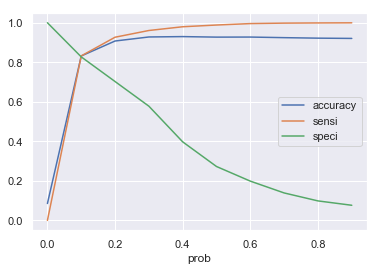

In [280]:
#to show the intersections: 
plt.figure(figsize=(40,40))
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [281]:
final_model(y_pred_final)

array([[6853, 1381],
       [ 133,  637]], dtype=int64)

0.8318525099955575

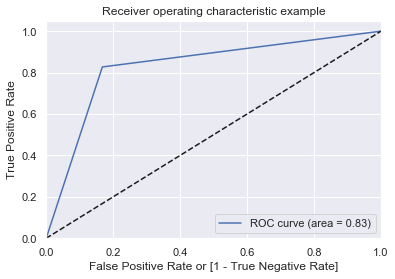

In [286]:
fig2 = draw_roc(y_pred_final.churn, y_pred_final.final_predicted)

**We can see that our 26 feature regularized Logistic regression model works equally better as the PCA model, we built earlier with 50 features!**.
<br>
This is a more generalized model and better.

**We will try other algorithms on the data and try to get the best model**
<br>

# <span style="color:green"><b>Decison Tree:</b></span>

In [287]:

# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus, graphviz

# Importing decision tree classifier from sklearn library
from sklearn.tree import DecisionTreeClassifier


# Create the parameter grid 
param_grid = {
    'max_depth': range(2, 20, 5),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
    'criterion': ["entropy", "gini"]
}

n_folds = 5

# Instantiate the grid search model
dtree = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator = dtree, param_grid = param_grid, 
                          cv = n_folds,return_train_score=True, verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  2.0min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': range(2, 20, 5), 'min_samples_leaf': range(50, 150, 50), 'min_samples_split': range(50, 150, 50), 'criterion': ['entropy', 'gini']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [312]:
# cv results
cv_decision_tree_results = pd.DataFrame(grid_search.cv_results_)
cv_decision_tree_results.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.281163,0.013854,0.005614,0.000492,entropy,2,50,50,"{'criterion': 'entropy', 'max_depth': 2, 'min_...",0.939315,...,0.937354,0.002353,1,0.937221,0.93853,0.936864,0.93776,0.937467,0.937568,0.000564
1,0.272407,0.007874,0.005815,0.000874,entropy,2,50,100,"{'criterion': 'entropy', 'max_depth': 2, 'min_...",0.939315,...,0.937354,0.002353,1,0.937221,0.93853,0.936864,0.93776,0.937467,0.937568,0.000564


In [289]:
print("best accuracy", grid_search.best_score_)
print(grid_search.best_estimator_)

best accuracy 0.9373542152615795
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=50,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


### As we can see the optimal parameters are max depth 2 .min_samples_leaf=50, min_samples_split=50, and criterion='entropy'
### so doing classifier with optimal parameters

In [313]:
#model with optimal hyperparameters
clf_entropy = DecisionTreeClassifier(criterion = "entropy",                                   
                                  max_depth=2, 
                                  min_samples_leaf=50,
                                  min_samples_split=50)
clf_entropy.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=50,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [314]:
# accuracy score
clf_entropy.score(X_test,y_test)

0.9424700133274101

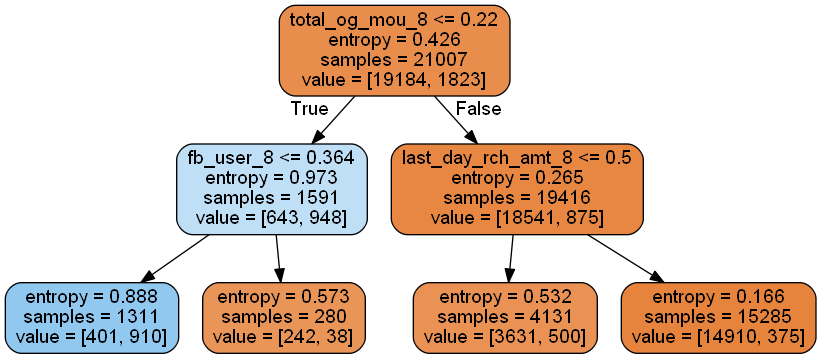

In [318]:
d_list =  list(cor_list)
d_list.extend(['mobile_number','churn']) ##dropping the cor list and the target values,index
df_features = PCA_churn.drop(d_list,axis=1)

features = list(df_features.columns)

dot_data = StringIO()  
export_graphviz(clf_entropy, out_file=dot_data,feature_names=features,filled=True,rounded=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

**Let's try tuning our churn probabilities to get a better model**

In [319]:
#Making prediction on the test data
pred_probs_test = clf_entropy.predict_proba(X_test)[:,1]
"{}".format(metrics.roc_auc_score(y_test, pred_probs_test))

'0.8409596415243732'

In [320]:
y_pred_final = probability_df(pred_probs_test,y_test)

array([[8088,  146],
       [ 372,  398]], dtype=int64)

In [321]:
model_evaluation(y_pred_final)

,churn,churn_Prob,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.121036,0,1,1,0,0,0,0,0,0,0,0
1,0,0.024534,0,1,0,0,0,0,0,0,0,0,0
2,0,0.024534,0,1,0,0,0,0,0,0,0,0,0
3,0,0.024534,0,1,0,0,0,0,0,0,0,0,0
4,0,0.024534,0,1,0,0,0,0,0,0,0,0,0


In [322]:
accuracy,sensi,speci,cutoff_df = probability_cutoff(y_pred_final)

     prob  accuracy     sensi     speci
0.0   0.0  0.085518  0.000000  1.000000
0.1   0.1  0.785096  0.783702  0.800000
0.2   0.2  0.942470  0.982269  0.516883
0.3   0.3  0.942470  0.982269  0.516883
0.4   0.4  0.942470  0.982269  0.516883
0.5   0.5  0.942470  0.982269  0.516883
0.6   0.6  0.942470  0.982269  0.516883
0.7   0.7  0.914482  1.000000  0.000000
0.8   0.8  0.914482  1.000000  0.000000
0.9   0.9  0.914482  1.000000  0.000000


<Figure size 2880x2880 with 0 Axes>

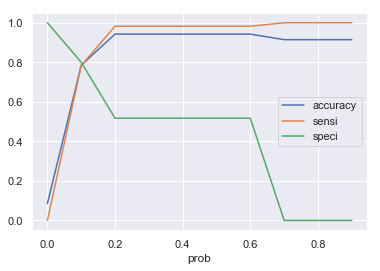

In [323]:
plt.figure(figsize=(40,40))
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [324]:
final_model(y_pred_final)

array([[6453, 1781],
       [ 154,  616]], dtype=int64)

0.7850955131052866

**Let's draw the ROC**

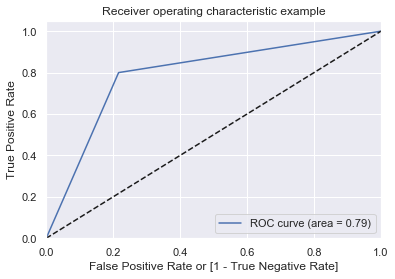

In [326]:
fig3 = draw_roc(y_pred_final.churn, y_pred_final.final_predicted)

<span style="color:red">Specificity=80%, accuracy = 78.5% </span>

# <span style="color:green">Random Forest</span>

In [327]:
# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier

# Running the random forest with default parameters.
rfc = RandomForestClassifier()

# fit
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [328]:
# Making predictions
predictions = rfc.predict(X_test)

In [329]:
# Let's check the report of our default model
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      8234
           1       0.78      0.45      0.57       770

   micro avg       0.94      0.94      0.94      9004
   macro avg       0.87      0.72      0.77      9004
weighted avg       0.94      0.94      0.94      9004



In [330]:
# Printing confusion matrix
print(confusion_matrix(y_test,predictions))

[[8136   98]
 [ 422  348]]


In [331]:
print(accuracy_score(y_test,predictions))

0.9422478898267437


**Model_tuning**

In [332]:
pred_probs_test = rfc.predict_proba(X_test)[:,1]
"{}".format(metrics.roc_auc_score(y_test, pred_probs_test))

'0.9012728345252028'

In [333]:
y_pred_final = probability_df(pred_probs_test,y_test)

array([[8136,   98],
       [ 422,  348]], dtype=int64)

In [334]:
model_evaluation(y_pred_final)

,churn,churn_Prob,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.3,0,1,1,1,0,0,0,0,0,0,0
1,0,0.1,0,1,0,0,0,0,0,0,0,0,0
2,0,0.0,0,0,0,0,0,0,0,0,0,0,0
3,0,0.0,0,0,0,0,0,0,0,0,0,0,0
4,0,0.0,0,0,0,0,0,0,0,0,0,0,0


In [335]:
accuracy,sensi,speci,cutoff_df = probability_cutoff(y_pred_final)

     prob  accuracy     sensi     speci
0.0   0.0  0.740338  0.725285  0.901299
0.1   0.1  0.875167  0.881467  0.807792
0.2   0.2  0.920813  0.939276  0.723377
0.3   0.3  0.938361  0.965995  0.642857
0.4   0.4  0.941915  0.979597  0.538961
0.5   0.5  0.942248  0.988098  0.451948
0.6   0.6  0.938805  0.992956  0.359740
0.7   0.7  0.932363  0.996114  0.250649
0.8   0.8  0.926699  0.998543  0.158442
0.9   0.9  0.920702  0.999393  0.079221


<Figure size 2880x2880 with 0 Axes>

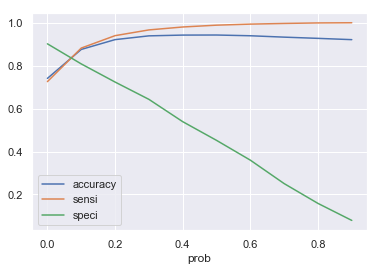

In [336]:
#to show the intersections: 
plt.figure(figsize=(40,40))
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [337]:
final_model(y_pred_final)

array([[7258,  976],
       [ 148,  622]], dtype=int64)

0.8751665926254998

<span style="color:red">Accuracy= 87.5%,Specificity = 81%</span>

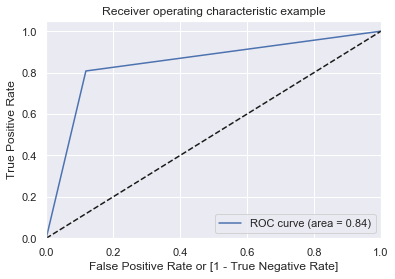

In [338]:
fig4 = draw_roc(y_pred_final.churn, y_pred_final.final_predicted)

**Hyper Parameter Tuning for Random Forest to get better results**
- <span style="color:blue">Max Depth</span>

In [339]:

# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(2, 20, 5)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                      cv=n_folds, 
                    return_train_score=True ,
                    scoring="accuracy")

rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': range(2, 20, 5)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='accuracy', verbose=0)

In [341]:
# plotting accuracies with max_depth

forest_scores = rf.cv_results_
pd.DataFrame(forest_scores).head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.154249,0.008786,0.008323,0.000245,2,{'max_depth': 2},0.927891,0.933127,0.919800,0.913592,...,0.925596,0.007788,4,0.928831,0.933948,0.923654,0.913543,0.935444,0.927084,0.007940
1,0.405974,0.007770,0.009937,0.000930,7,{'max_depth': 7},0.938363,0.936221,0.936221,0.940252,...,0.937783,0.001505,1,0.944540,0.944659,0.944897,0.944901,0.945380,0.944876,0.000288


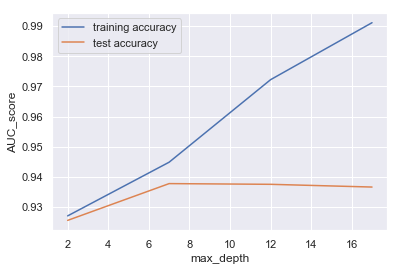

In [342]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(forest_scores["param_max_depth"], 
         forest_scores["mean_train_score"], 
         label="training accuracy")
plt.plot(forest_scores["param_max_depth"], 
         forest_scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("AUC_score") #Changed this to AUC score
plt.legend()
plt.show()

- <span style="color:grey">Max Depth is fixed at 7</span>
- <span style="color:blue"><i>Let's find Max features<i></span>

In [343]:
# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_features': [4,8,14]}

# instantiate the model
rf = RandomForestClassifier(max_depth=7)


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds,
                  return_train_score=True ,
                   scoring="accuracy")
rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_features': [4, 8, 14]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='accuracy', verbose=0)

In [344]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.199328,0.010470,0.010327,0.001213,4,{'max_features': 4},0.936221,0.933127,0.936221,0.941204,...,0.936783,0.002595,3,0.940732,0.940494,0.942458,0.939129,0.940977,0.940758,0.001064
1,0.336094,0.009157,0.010023,0.000894,8,{'max_features': 8},0.937649,0.937173,0.938363,0.940490,...,0.938068,0.001334,2,0.943767,0.944778,0.942458,0.942045,0.943773,0.943364,0.000989


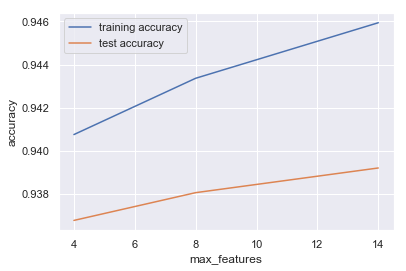

In [345]:
# plotting accuracies with max_features
plt.figure()
plt.plot(scores["param_max_features"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_features"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_features")
plt.ylabel("accuracy") #changed it to AUC score
plt.legend()
plt.show()

## Grid Search with tuned hyper parameters

In [346]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [4,8],
    'min_samples_leaf': range(100, 400, 200),
    'min_samples_split': range(200, 500, 200), 
    'max_features': [5, 10,15]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1,verbose = 1)

In [347]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   13.5s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [4, 8], 'min_samples_leaf': range(100, 400, 200), 'min_samples_split': range(200, 500, 200), 'max_features': [5, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [348]:
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

We can get accuracy of 0.936735373922978 using {'max_depth': 8, 'max_features': 10, 'min_samples_leaf': 100, 'min_samples_split': 400}


In [349]:
rfc = RandomForestClassifier(max_depth= 8,
                             min_samples_leaf=100, 
                             min_samples_split=400,
                             max_features=10)
# fit
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=100, min_samples_split=400,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [350]:
# predict
predictions = rfc.predict(X_test)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      8234
           1       0.82      0.41      0.54       770

   micro avg       0.94      0.94      0.94      9004
   macro avg       0.88      0.70      0.76      9004
weighted avg       0.94      0.94      0.93      9004



In [351]:
print(confusion_matrix(y_test,predictions))

[[8165   69]
 [ 456  314]]


In [352]:
print(accuracy_score(y_test,predictions))

0.9416925810750777


In [353]:
pred_probs_test = rfc.predict_proba(X_test)[:,1]
"{}".format(metrics.roc_auc_score(y_test, pred_probs_test))

'0.9351661940197282'

In [354]:
y_pred_final = probability_df(pred_probs_test,y_test)

array([[8165,   69],
       [ 456,  314]], dtype=int64)

In [355]:
model_evaluation(y_pred_final)

,churn,churn_Prob,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.268553,0,1,1,1,0,0,0,0,0,0,0
1,0,0.173172,0,1,1,0,0,0,0,0,0,0,0
2,0,0.034681,0,1,0,0,0,0,0,0,0,0,0
3,0,0.006767,0,1,0,0,0,0,0,0,0,0,0
4,0,0.021442,0,1,0,0,0,0,0,0,0,0,0


In [356]:
accuracy,sensi,speci,cutoff_df = probability_cutoff(y_pred_final)

     prob  accuracy     sensi     speci
0.0   0.0  0.085518  0.000000  1.000000
0.1   0.1  0.846179  0.843211  0.877922
0.2   0.2  0.925589  0.946077  0.706494
0.3   0.3  0.937694  0.972553  0.564935
0.4   0.4  0.941026  0.983726  0.484416
0.5   0.5  0.941693  0.991620  0.407792
0.6   0.6  0.932363  0.996357  0.248052
0.7   0.7  0.915482  1.000000  0.011688
0.8   0.8  0.914482  1.000000  0.000000
0.9   0.9  0.914482  1.000000  0.000000


<Figure size 2880x2880 with 0 Axes>

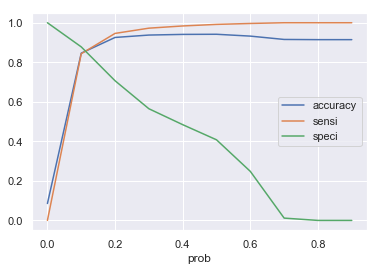

In [357]:
plt.figure(figsize=(40,40))
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [358]:
final_model(y_pred_final)

array([[6943, 1291],
       [  94,  676]], dtype=int64)

0.8461794757885385

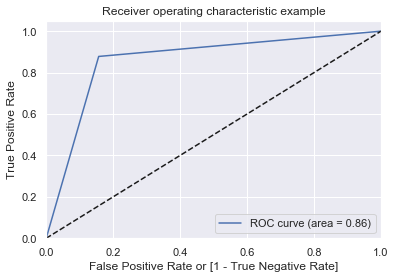

In [360]:
fig5 = draw_roc(y_pred_final.churn, y_pred_final.final_predicted)

<span style="color:red"><b>Specificity = 89% , Accuracy = 85% - with only 10 features!<b> </span>

Let's get the feature list by importance

In [398]:
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
rel_list = list(feature_importances[feature_importances.importance>0.03].index)

In [408]:
rel_list.append('churn')#append the churn because it is against churn that we'll plot the graphs

In [401]:
df_features = PCA_churn[rel_list]

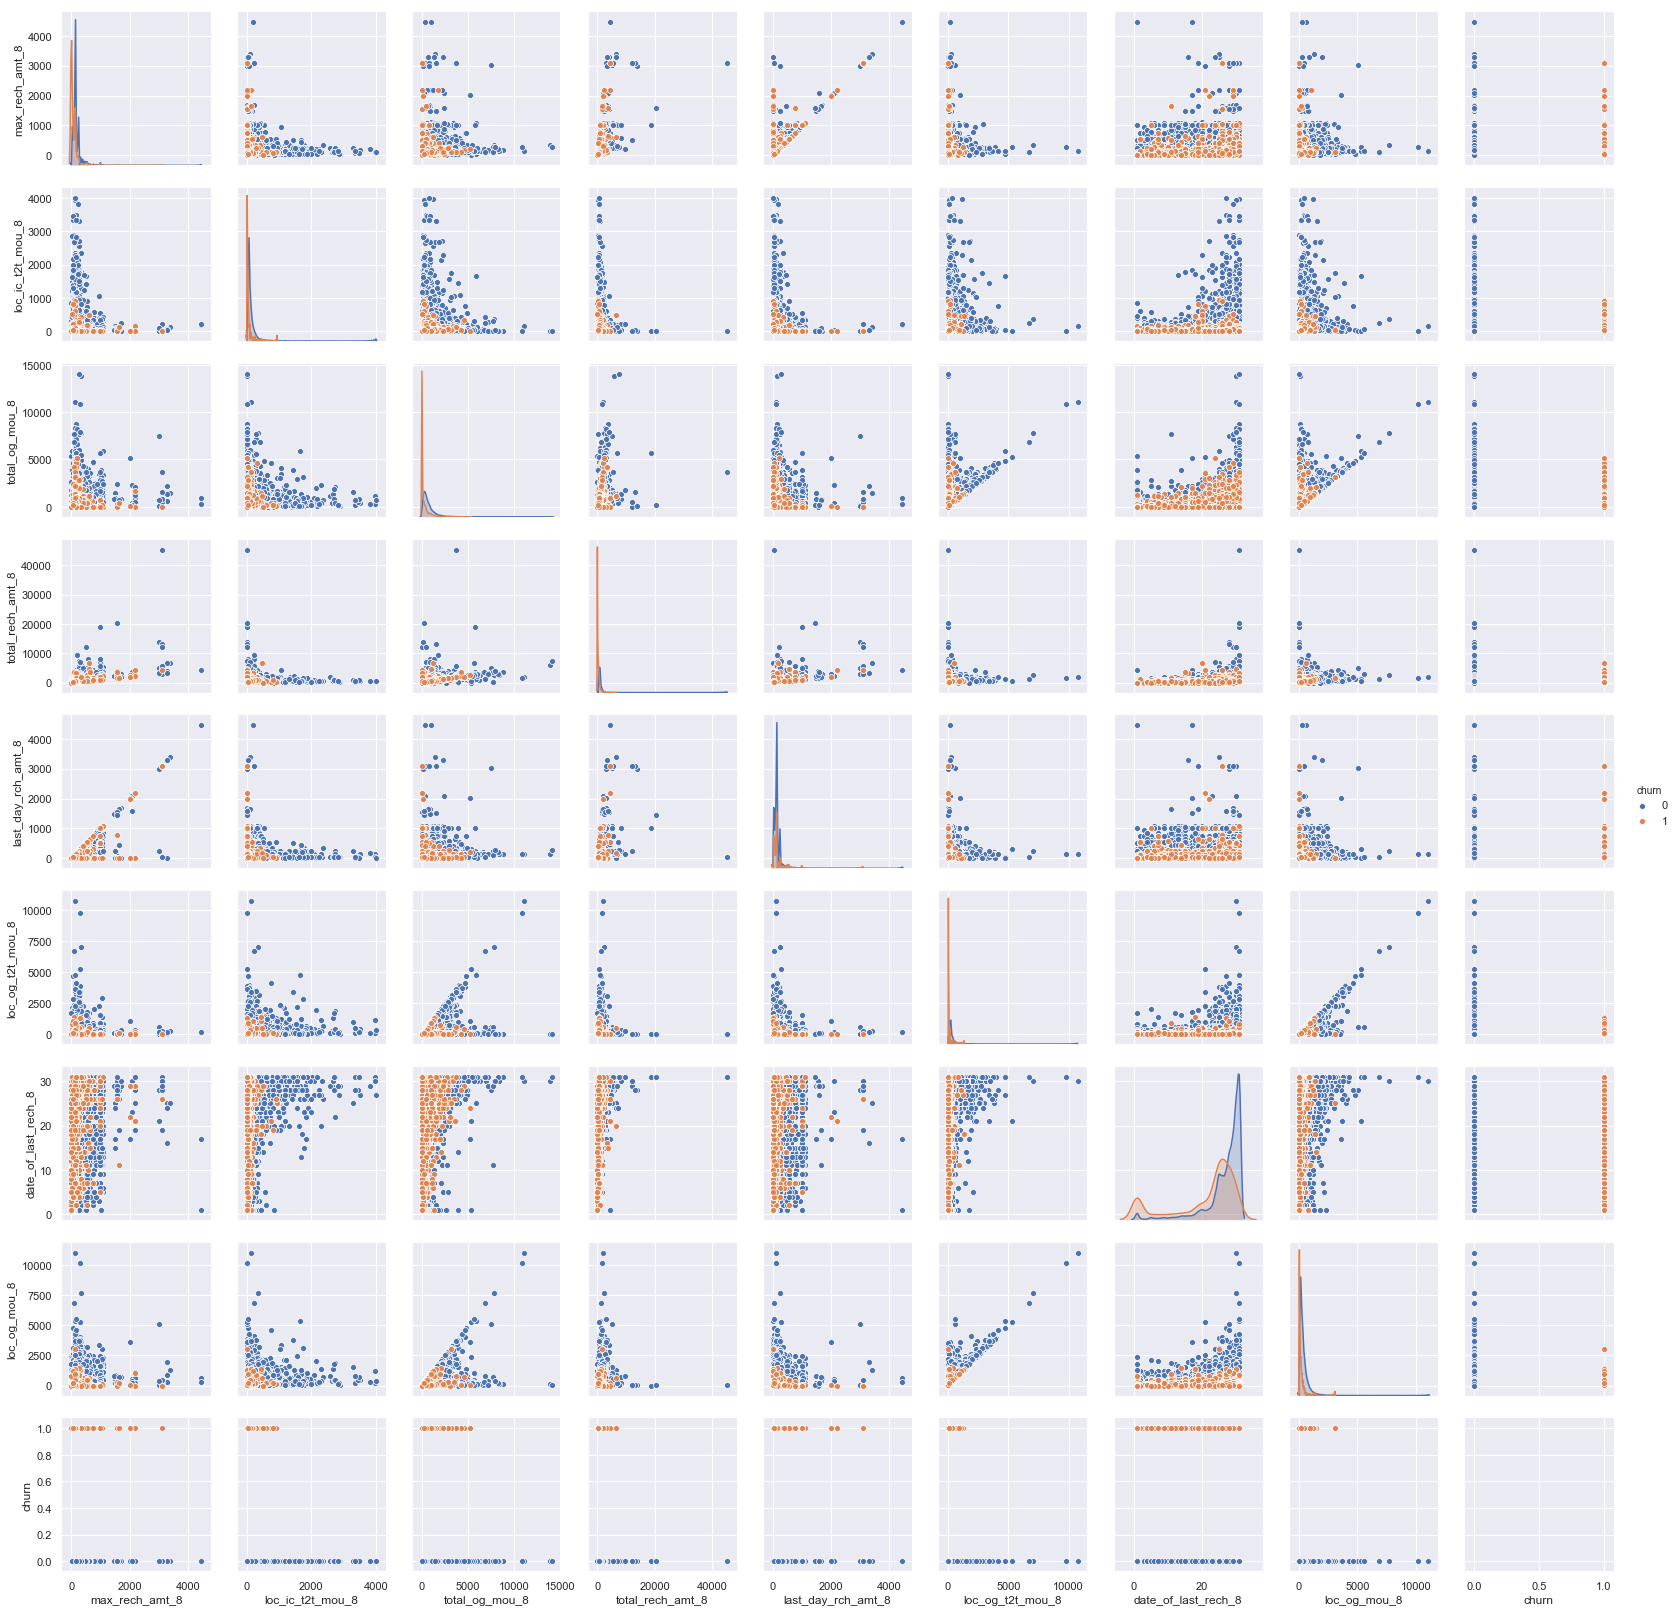

In [403]:
sns.pairplot(df_features, hue = 'churn')

<p style="text-align: left;"><span style="color: #000080;"><strong>As per pair plot above we can see that the main features influencing churn are:</strong></span><br /><span style="color: #339966;">- total_rech_amt_8: The amount of recharge done in 8th month</span><br /><span style="color: #339966;">- total_og_mou_8: The amount of out going minutes of usage for month_8</span><br /><span style="color: #339966;">- date_of_last_rech_8: The date of the last recharge in the 8th month</span><br /><span style="color: #339966;">- max_rech_amt_8: The maximum recharge done in 8th month</span></p>

### Ada boost

#### Checking accuracy using the AdaBoost .
#### Calculating  the accuracy of the AdaBoost models as we increase the number of trees from 1 to 50 with a step of 5

In [363]:
from sklearn.ensemble import AdaBoostClassifier

estimators = list(range(1, 50, 5))

abc_scores = []
for n_est in estimators:
    ABC = AdaBoostClassifier(
    base_estimator=tree_depth_3, 
    n_estimators = n_est)
    
    ABC.fit(X_train, y_train)
    y_pred = ABC.predict(X_test)
    score = metrics.accuracy_score(y_test, y_pred)
    abc_scores.append(score)
    

- **get the number of estimators**

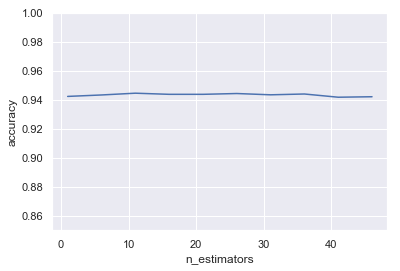

In [364]:
plt.plot(estimators, abc_scores)
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.ylim([0.85, 1])
plt.show()

- #### Checking accuracy using GradientBoost .

In [368]:
from sklearn.ensemble import GradientBoostingClassifier

learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=20, learning_rate = learning_rate, max_features=8, max_depth = 2, random_state = 0)
    gb.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train, y_train)))
    print("Accuracy score (test): {0:.3f}".format(gb.score(X_test, y_test)))


Learning rate:  0.05
Accuracy score (training): 0.915
Accuracy score (test): 0.916
Learning rate:  0.1
Accuracy score (training): 0.935
Accuracy score (test): 0.940
Learning rate:  0.25
Accuracy score (training): 0.936
Accuracy score (test): 0.939
Learning rate:  0.5
Accuracy score (training): 0.935
Accuracy score (test): 0.937
Learning rate:  0.75
Accuracy score (training): 0.935
Accuracy score (test): 0.935
Learning rate:  1
Accuracy score (training): 0.935
Accuracy score (test): 0.937


- learning rate = 0.25
- n_estimators = 12

In [369]:
gb = GradientBoostingClassifier(n_estimators=12, learning_rate = 0.25, max_features=8, max_depth = 2, random_state = 0)
gb.fit(X_train, y_train)
predictions = gb.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))
print()
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix:
[[8124  110]
 [ 466  304]]

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      8234
           1       0.73      0.39      0.51       770

   micro avg       0.94      0.94      0.94      9004
   macro avg       0.84      0.69      0.74      9004
weighted avg       0.93      0.94      0.93      9004



In [370]:
# ROC curve and Area-Under-Curve (AUC)
from sklearn.metrics import roc_curve, auc

y_scores_gb = gb.decision_function(X_test)
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_scores_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)

print("Area under ROC curve = {:0.2f}".format(roc_auc_gb))

Area under ROC curve = 0.93


In [371]:
pred_probs_test = gb.predict_proba(X_test)[:,1]
"{}".format(metrics.roc_auc_score(y_test, pred_probs_test))

'0.9271168168727071'

In [372]:
y_pred_final = probability_df(pred_probs_test,y_test)

array([[8124,  110],
       [ 466,  304]], dtype=int64)

In [373]:
model_evaluation(y_pred_final)

,churn,churn_Prob,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.133738,0,1,1,0,0,0,0,0,0,0,0
1,0,0.157109,0,1,1,0,0,0,0,0,0,0,0
2,0,0.020100,0,1,0,0,0,0,0,0,0,0,0
3,0,0.024564,0,1,0,0,0,0,0,0,0,0,0
4,0,0.038701,0,1,0,0,0,0,0,0,0,0,0


In [374]:
accuracy,sensi,speci,cutoff_df = probability_cutoff(y_pred_final)

     prob  accuracy     sensi     speci
0.0   0.0  0.085518  0.000000  1.000000
0.1   0.1  0.899822  0.911465  0.775325
0.2   0.2  0.934918  0.965995  0.602597
0.3   0.3  0.941137  0.980325  0.522078
0.4   0.4  0.938250  0.983726  0.451948
0.5   0.5  0.936028  0.986641  0.394805
0.6   0.6  0.936917  0.989920  0.370130
0.7   0.7  0.936473  0.991499  0.348052
0.8   0.8  0.924034  0.997571  0.137662
0.9   0.9  0.914482  1.000000  0.000000


<Figure size 2880x2880 with 0 Axes>

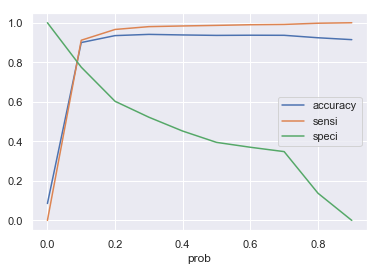

In [375]:

plt.figure(figsize=(40,40))
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [376]:
final_model(y_pred_final)

array([[7505,  729],
       [ 173,  597]], dtype=int64)

0.8998223011994669

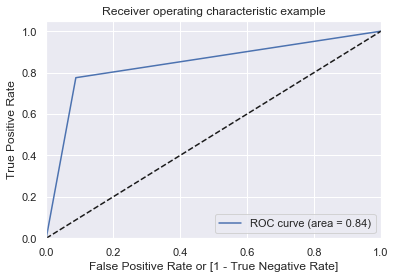

In [378]:
fig6 = draw_roc(y_pred_final.churn, y_pred_final.final_predicted)

## <p style="text-align: center;"><span style="background-color: #ffffff; color: #339966;"><em><strong> SUMMARY </strong></em></span></p>

<p style="text-align: center;"><span style="background-color: #ffffff; color: #000000;"><strong>Strategies to manage customer churn:</strong></span></p>

<table style="font-weight: 400;">
<tbody>
<tr>
<td width="312">
<p>Age on network</p>
</td>
<td width="312">
<p>Recognizing or congratulating customer for completion of &ldquo;one more month&rdquo; and incentivizing with additional call or data points for completing 3, 6,9 or 12 month milestone</p>
</td>
</tr>
<tr>
<td width="312">
<p>Maximum Recharge Amount, Total number of recharges</p>
</td>
<td width="312">
<p>Customers recharging with high amounts and less number of recharge counts in a month indicates their loyalty to the network. Can service provider builds a scheme on more the recharge amount, more will be the befits</p>
</td>
</tr>
<tr>
<td width="312">
<p>Off Network minute usage, Local incoming from other operator mobile, Local outgoing to other operator mobile</p>
</td>
<td width="312">
<p>Churn dependencies on these driver variables indicate the zone has too many telecom operators leading to high cross operator call volume. Our service provider should provide smooth call switch for incoming or outgoing to enable smooth end user experience. bad experience of inter operator call switch will lead to churn</p>
</td>
</tr>
<tr>
<td width="312">
<p>Roaming Incoming and roaming outgoing minute of usage</p>
</td>
<td width="312">
<p>Being high value customers, roaming usage will be high. Any tendency to charge high amount competed to competition will lead to customer dissatisfaction. &nbsp;The service provider should re-look at the roaming charges and policies.</p>
</td>
</tr>
<tr>
<td width="312">
<p>Average revenue per user</p>
</td>
<td width="312">
<p>We can see a gradual reduction in this , as the customer spent very low amount in action month , before he/she decides to churn out from network.</p>
<p>So strategy is to target high value customer s who are suddenly spending less amouint than they use to</p>
</td>
</tr>
</tbody>
</table>
<p>&nbsp;</p>